In [101]:
# To activate this environment, use                                             
#                                                                               
#     $ conda activate gee                                                      
#                                                                               
# To deactivate an active environment, use                                      
#                                                                               
#     $ conda deactivate   

# Importing datasets
Import data and establish bounds for ROI

In [1]:
# Import libraries

import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt



In [2]:
# Connect to GEE
ee.Authenticate()
ee.Initialize(project='wildfire-risk-ml')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [3]:
# Create Map Canvas
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
# Add maule region to map

regions = gpd.read_file("Regiones/Regional.shp")
# Fix CRS for regions
regions = regions.to_crs("EPSG:4326")
maule_gpd = regions[regions['Region'] == 'Región del Maule'] # Filter to Maule
maule_gpd.to_file("maule_region.shp", driver="ESRI Shapefile")
maule = geemap.geopandas_to_ee(maule_gpd) # convert to ee object




In [ ]:
Map = geemap.Map()
Map.addLayer(maule,{},"Maule") # Add CHile to map
chile = ee.Geometry.Polygon([[
    [-75, -60],
    [-75, -17],
    [-66, -17],
    [-66, -60],
    [-75, -60]
]])
Map.centerObject(chile, 8) # Center on Chile
Map


In [5]:
regions = gpd.read_file("Regiones/Regional.shp")
regions.crs
regions = regions.to_crs("EPSG:4326")
regions.to_file("Regiones/Regional.shp")


In [6]:
# Pull in LandSat Data
#landsat_5 = ee.ImageCollection("LANDSAT/LT05/C02/T1").filterDate("1984-04-19","2011-11-08").filterBounds(maule)
#landsat_7 = ee.ImageCollection("LANDSAT/LE07/C02/T1").filterDate("2011-11-08","2013-03-18").filterBounds(maule)
landsat_8 = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate("2013-03-18","2018-12-31").filterBounds(maule)

# Cloud mask removal - make composite image
#composite_5 = ee.Algorithms.Landsat.simpleComposite(**
#{
#    'collection':landsat_5,
#    'asFloat': True                                     
#})
#composite_7 = ee.Algorithms.Landsat.simpleComposite(**
#{
#    'collection':landsat_7,
#    'asFloat': True                                     
#})

composite_8 = ee.Algorithms.Landsat.simpleComposite(**
{
    'collection':landsat_8,
    'asFloat': True                                     
})
#composite_7 = composite_7.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']) \
#                         .toShort()




In [7]:
#Display simple visualization

rgbVis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': .3}  # Display simple visualization
Map.addLayer(composite_8.clip(maule), rgbVis, 'RGB Viz 8')
#Map.addLayer(composite_5.clip(maule), rgbVis, '
# RGB Viz 5')
Map

Map(bottom=40188.0, center=[-36.386943716012844, -70.49999999999999], controls=(WidgetControl(options=['positi…

# Feature Engineering
Data pre-processing to calculate NDVI, NBR, 

In [11]:
# Calculate NDVI

# Calculate NBR

# Add as layer to map






### Machine Learning Classification of Land Cover

In [12]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  """Scales and masks Landsat 8 surface reflectance images."""
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2021-03-01', '2021-07-01')
    .map(prep_sr_l8)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load training points. The numeric property 'class' stores known labels.
points = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# This property stores the land cover labels as consecutive
# integers starting from zero.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = l8_image.select(bands).sampleRegions(
    collection=points, properties=[label], scale=30
)

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

# Classify the image with the same bands used for training.
classified = l8_image.select(bands).classify(trained)

# Display the inputs and the results.
m = geemap.Map()
m.set_center(-122.0877, 37.7880, 11)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(
    classified,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},
    'classification',
)
m

Map(center=[37.788, -122.0877], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

In [112]:
shapefile_path = "land_use_data/cleaned_shapefile.shp"

# Load the shapefile
gdf_landuse = gpd.read_file(shapefile_path)

subuso_area = gdf_landuse.groupby('SUBUSO')['SUPERF_HA'].sum().reset_index()
subuso_area = subuso_area.sort_values(by='SUPERF_HA', ascending=False)

# Display the result
print(subuso_area)

                                    SUBUSO  SUPERF_HA
10                              Plantación  634893.44
1                            Bosque Nativo  581514.91
13                 Terreno de Uso Agrícola  372299.89
4                                 Matorral  221057.01
11                                Praderas  169435.96
5                    Matorral Arborescente  117746.77
7                         Matorral-Pradera   54951.18
9                                   Nieves   48363.01
0                             Bosque Mixto   28674.71
2    Ciudades, Pueblos, Zonas Industriales   26086.44
3       Lagos, Lagunas, Embalses, Tranques   18984.84
12                                    Ríos   17084.91
15  Vegetación Herbácea en Orillas de Ríos     521.79
8                       Minería Industrial     516.38
14                                   Vegas     488.52
6                  Matorral con Suculentas     215.52


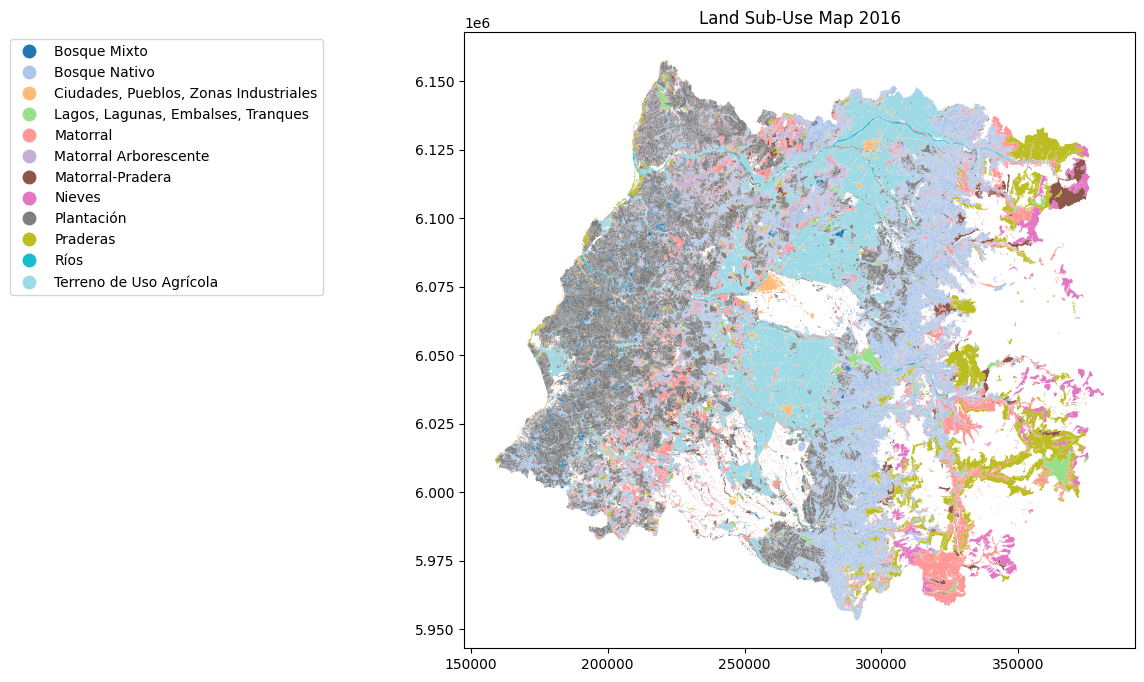

In [113]:
# Filter the dataset
selected_subuso = [
    'Plantación', 'Bosque Nativo', 'Bosque Mixto', 'Terreno de Uso Agrícola', 
    'Matorral', 'Praderas', 'Afloramientos Rocosos', 'Matorral Arborescente', 
    'Matorral-Pradera', 'Nieves', 'Ciudades, Pueblos, Zonas Industriales', 
    'Lagos, Lagunas, Embalses, Tranques', 'Ríos'
]

gdf_filtered = gdf_landuse[gdf_landuse['SUBUSO'].isin(selected_subuso)]

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_filtered.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)
#gdf.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)

# Adjust legend position to the left
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.2, 1))  # Moves the legend outside the plot to the left

# Add title
plt.title("Land Sub-Use Map 2016")

plt.show()

NameError: name 'gdf_landuse' is not defined

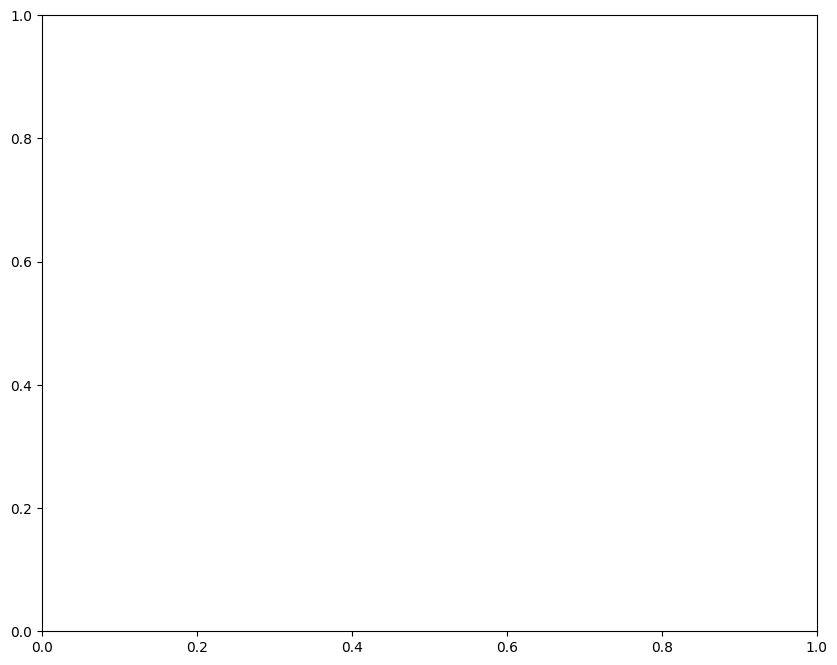

In [9]:

fig, ax = plt.subplots(figsize=(10, 8))
#gdf_filtered.plot(column='SUBUSO', cmap='tab20', legend=True, ax=ax)
gdf_landuse.plot(column='USO', cmap='tab20', legend=True, ax=ax)

# Adjust legend position to the left
leg = ax.get_legend()
leg.set_bbox_to_anchor((-0.2, 1))  # Moves the legend outside the plot to the left

# Add title
plt.title("Land Use Map 2016")

plt.show()

In [115]:
gdf_landuse = gdf_landuse.to_crs("EPSG:4326")
landuse = geemap.geopandas_to_ee(gdf_landuse) # convert to ee object


In [116]:
# Load the 2020 Landsat 8 surface reflectance image collection
l8_image_2020 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2020-01-01', '2020-12-31')  # Use 2020 image data
    .map(prep_sr_l8)  # Apply the prep_sr_l8 function for scaling and masking
    .median()  # Create a composite
)

In [117]:
# Define bands for training (e.g., Red, Green, Blue, NIR, etc.)
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load the output feature collection from 2016 (uploaded to Earth Engine)
# Replace with the path to your 2016 labeled points
points_2016 = ee.FeatureCollection('land_use_data/output_feature_collection.geojson')


In [118]:

# Define the label field (numeric property created from SUBUSO)
label = 'SUBUSO_numeric'  # Replace with the actual field name if it's different

# Overlay the points from 2016 on the 2020 image to get training data
training_2020 = l8_image_2020.select(bands).sampleRegions(
    collection=points_2016, properties=[label], scale=30, geometries=True
)

In [119]:
# Train the classifier (CART classifier in this case)
trained_classifier = ee.Classifier.smileCart().train(training_2020, label, bands)

# Apply the trained classifier to the 2020 image
classified_2020 = l8_image_2020.select(bands).classify(trained_classifier)


In [120]:
m = geemap.Map()
 # Change this to the center of your region
m.add_layer(
    l8_image_2020,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'Landsat 8 Composite 2020'
)

# Add the classified 2020 image to the map (show classification results)
m.add_layer(
    classified_2020,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},  # Adjust palette as needed
    'Classification 2020'
)

# Display the map
m

EEException: Collection.loadTable: Collection asset 'land_use_data/output_feature_collection.geojson' not found.

In [ ]:
pwd

'/Users/abbystokes/Documents/GitHub/wildfire-risk-ml'